# Create gridded SIF and XCO2 residuals for 2020-07 using lon, lat, and evi covariates

In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import xarray as xr
import xesmf as xe
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

from cmcrameri import cm
import seaborn as sns
import plot

In [3]:
year = 2020
month = 7
offset = 1
month_xco2 = month + offset

## SIF residuals

In [4]:
# read in the sif data and evi covariate
extents = {"lon0_b": -125, "lon1_b": -65, "lat0_b": 22, "lat1_b": 58}
with xr.open_dataset("../data/exp_pro/MODIS_EVI_conus.nc") as ds:
    ds_evi = ds.sel(time=f"{year}-0{month}").squeeze()
    bounds = (
        (ds.lon >= extents["lon0_b"])
        & (ds.lon <= extents["lon1_b"])
        & (ds.lat >= extents["lat0_b"])
        & (ds.lat <= extents["lat1_b"])
    )
    ds_evi = ds_evi.where(bounds, drop=True)


with xr.open_dataset(f"005_deg_gridded_sif_{year}0{month}.nc") as ds_sif:
    # EVI dataset is oriented with latitude in decreasing order; flip to match SIF dataset
    ds_sif["evi"] = (["lon", "lat"], np.fliplr(ds_evi["evi"].values).astype(np.float64))
    
ds_sif

<xarray.Dataset>
Dimensions:  (lon: 1200, lat: 720)
Coordinates:
  * lon      (lon) float64 -125.0 -124.9 -124.9 -124.8 ... -65.13 -65.08 -65.03
  * lat      (lat) float64 22.02 22.08 22.12 22.18 ... 57.83 57.88 57.93 57.98
Data variables:
    sif      (lon, lat) float32 ...
    evi      (lon, lat) float64 nan nan nan ... 3.069e+07 2.898e+07 2.862e+07

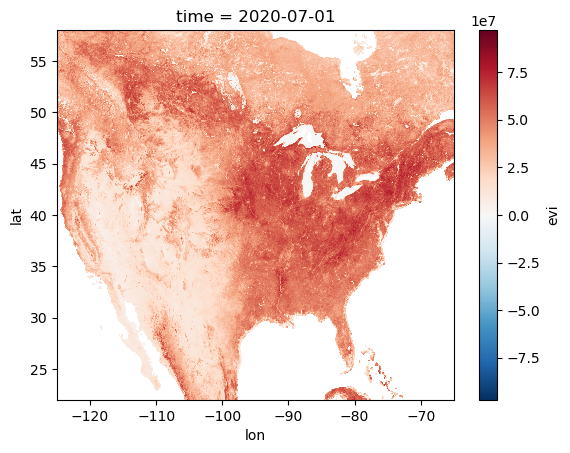

In [5]:
ds_evi["evi"].T.plot()

In [6]:
df_sif = ds_sif.to_dataframe().reset_index()[["lon", "lat", "evi", "sif"]]

# standardize the covariates
X = df_sif[["lon", "lat", "evi"]].values
df_sif[["lon_std", "lat_std", "evi_std"]] = (X - np.nanmean(X, axis=0)) / np.nanstd(
    X, ddof=1, axis=0
)

df_sif = df_sif.dropna(how="any")

df_sif.head()


,lon,lat,evi,sif,lon_std,lat_std,evi_std
536,-124.975,48.825,58010000.0,0.583535,-1.730607,0.849186,1.268572
537,-124.975,48.875,51790000.0,0.528290,-1.730607,0.853998,0.896696
538,-124.975,48.925,50420000.0,0.480016,-1.730607,0.858809,0.814787
539,-124.975,48.975,42560000.0,0.255563,-1.730607,0.863620,0.344861
540,-124.975,49.025,54690000.0,0.528821,-1.730607,0.868431,1.070078


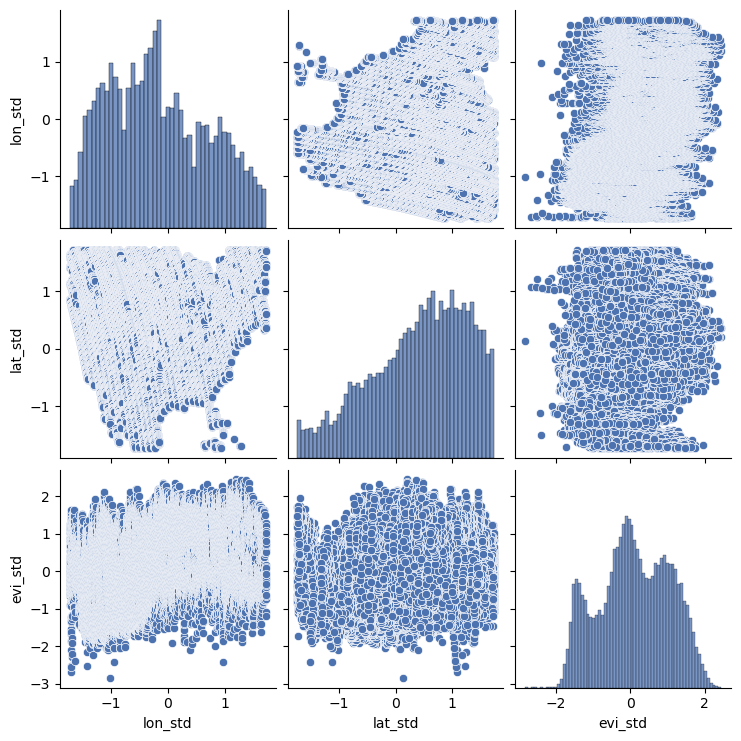

In [7]:
sns.pairplot(df_sif[["lon_std", "lat_std", "evi_std"]])

In [8]:
# model = smf.ols(
#     formula="sif ~ evi_std", data=df_sif
# ).fit()
model = smf.ols(
    formula="sif ~ lat_std + lon_std + evi_std", data=df_sif
).fit()
# model = smf.ols(
#     formula="sif ~ np.power(lat_std, 2)*np.power(lon_std, 2) + evi_std", data=df_sif
# ).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    sif   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                 3.312e+04
Date:                Tue, 20 Sep 2022   Prob (F-statistic):               0.00
Time:                        11:11:01   Log-Likelihood:                 11018.
No. Observations:               47562   AIC:                        -2.203e+04
Df Residuals:                   47558   BIC:                        -2.199e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4207      0.001    419.604      0.000       0.419       0.423
lat_std       -0.0186      0.001    -17.572      0.000      -0.021      -0.016
lon_std       -0.0120      0.001    -10.918      0.000      -0.014      -0.010
evi_std        0.2974      0.001    293.504      0.000       0.295       0.299
==============================================================================
Omnibus:                     4730.621   Durbin-Watson:                   1.444
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34506.938
Skew:                           0.174   Prob(JB):                         0.00
Kurtosis:                       7.158   Cond. No.                         1.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
# covariates = df[["lon_std", "lat_std", "evi_std"]].copy()
# model = LinearRegression().fit(covariates, df["sif"])
# df["ols_mean"] = model.predict(covariates)
df_sif["ols_mean"] = model.predict()
df_sif["sif_residuals"] = df_sif["sif"] - df_sif["ols_mean"]
df_sif["sif_residuals_std"] = (
    df_sif["sif_residuals"] - df_sif["sif_residuals"].mean()
) / df_sif["sif_residuals"].std()
df_sif


,lon,lat,evi,sif,lon_std,lat_std,evi_std,ols_mean,sif_residuals,sif_residuals_std
536,-124.975,48.825,58010000.0,0.583535,-1.730607,0.849186,1.268572,0.802973,-0.219438,-1.143286
537,-124.975,48.875,51790000.0,0.528290,-1.730607,0.853998,0.896696,0.692290,-0.164000,-0.854451
538,-124.975,48.925,50420000.0,0.480016,-1.730607,0.858809,0.814787,0.667842,-0.187826,-0.978585
539,-124.975,48.975,42560000.0,0.255563,-1.730607,0.863620,0.344861,0.527999,-0.272436,-1.419408
540,-124.975,49.025,54690000.0,0.528821,-1.730607,0.868431,1.070078,0.743585,-0.214764,-1.118935
...,...,...,...,...,...,...,...,...,...,...
863766,-65.025,46.325,53750000.0,0.723779,1.730607,0.608624,1.013879,0.690178,0.033601,0.175061
863934,-65.025,54.725,26410000.0,0.256006,1.730607,1.416914,-0.620701,0.189061,0.066946,0.348790
863935,-65.025,54.775,30860000.0,-0.030848,1.730607,1.421726,-0.354649,0.268094,-0.298942,-1.557507
863936,-65.025,54.825,32140000.0,-0.253089,1.730607,1.426537,-0.278121,0.290764,-0.543853,-2.833503


In [10]:
df_sif[["ols_mean", "sif_residuals", "sif_residuals_std"]].describe()

,ols_mean,sif_residuals,sif_residuals_std
count,47562.000000,4.756200e+04,4.756200e+04
mean,0.446176,7.170861e-17,-4.780574e-18
std,0.277447,1.919365e-01,1.000000e+00
min,-0.413197,-1.398142e+00,-7.284399e+00
25%,0.240975,-1.059858e-01,-5.521921e-01
50%,0.434001,-7.900399e-03,-4.116153e-02
75%,0.675235,1.015905e-01,5.292923e-01
max,1.130226,2.580321e+00,1.344362e+01


/home/jj829/sif-xco2-cokriging/l2_north_america/../src/plot.py:175: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("roma_r"))
  cmap.set_bad(color="red")


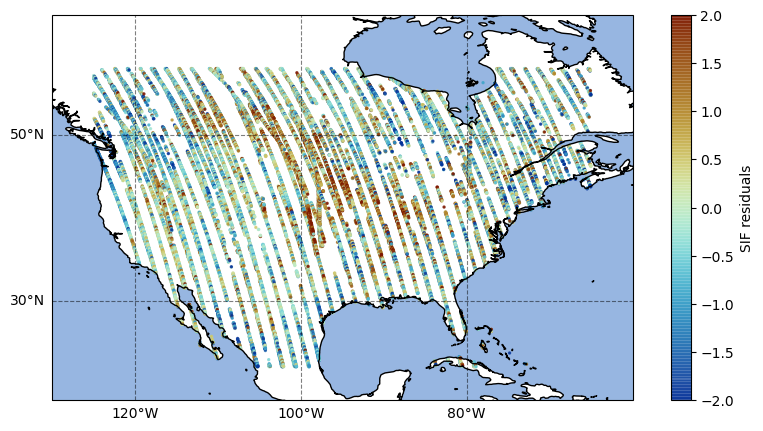

In [11]:
plot.plot_df(df_sif, "sif_residuals_std", vmin=-2, vmax=2, cmap=cm.roma_r, label="SIF residuals");

In [12]:
df_sif.to_csv("gridded_sif_residuals_north_america.csv", index=False)

## XCO2 residuals

In [4]:
# read in the xco2 data
ds_xco2 = xr.open_dataset(f"005_deg_gridded_xco2_{year}0{month_xco2}.nc")
ds_xco2

<xarray.Dataset>
Dimensions:  (lon: 1171, lat: 720)
Coordinates:
  * lon      (lon) float64 -125.0 -124.9 -124.9 -124.8 ... -65.13 -65.08 -65.03
  * lat      (lat) float64 22.02 22.08 22.12 22.18 ... 57.83 57.88 57.93 57.98
Data variables:
    xco2     (lon, lat) float32 ...

In [5]:
df_xco2 = ds_xco2.to_dataframe().reset_index()[["lon", "lat", "xco2"]]

# standardize the covariates
X = df_xco2[["lon", "lat"]].values
df_xco2[["lon_std", "lat_std"]] = (X - np.nanmean(X, axis=0)) / np.nanstd(
    X, ddof=1, axis=0
)

df_xco2 = df_xco2.dropna(how="any")

df_xco2.head()


,lon,lat,xco2,lon_std,lat_std
287,-124.975,36.375,410.178192,-1.713502,-0.348816
288,-124.975,36.425,410.003754,-1.713502,-0.344005
289,-124.975,36.475,409.927368,-1.713502,-0.339193
290,-124.975,36.525,409.908722,-1.713502,-0.334382
434,-124.975,43.725,408.020203,-1.713502,0.358438


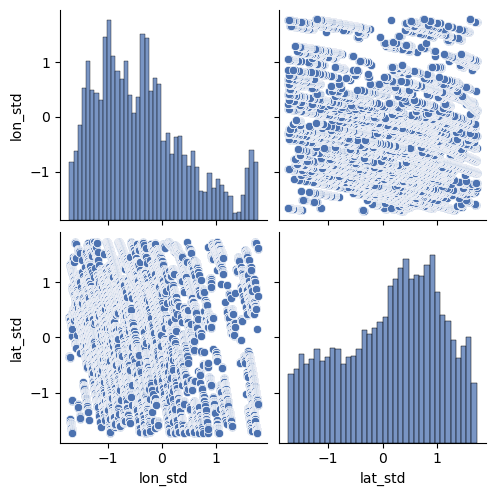

In [6]:
sns.pairplot(df_xco2[["lon_std", "lat_std"]])

In [7]:
model = smf.ols(
    formula="xco2 ~ lat_std + lon_std", data=df_xco2
).fit()
# model = smf.ols(
#     formula="xco2 ~ np.power(lat_std, 2)*np.power(lon_std, 2)", data=df_xco2
# ).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   xco2   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     8554.
Date:                Tue, 20 Sep 2022   Prob (F-statistic):               0.00
Time:                        11:15:00   Log-Likelihood:                -46813.
No. Observations:               23080   AIC:                         9.363e+04
Df Residuals:                   23077   BIC:                         9.366e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    409.3683      0.013   3.05e+04      0.000     409.342     409.395
lat_std       -1.6579      0.013   -122.911      0.000      -1.684      -1.631
lon_std       -0.8505      0.015    -58.579      0.000      -0.879      -0.822
==============================================================================
Omnibus:                      601.676   Durbin-Watson:                   0.796
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1401.424
Skew:                          -0.093   Prob(JB):                    4.84e-305
Kurtosis:                       4.193   Cond. No.                         1.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
df_xco2["ols_mean"] = model.predict()
df_xco2["xco2_residuals"] = df_xco2["xco2"] - df_xco2["ols_mean"]
df_xco2["xco2_residuals_std"] = (
    df_xco2["xco2_residuals"] - df_xco2["xco2_residuals"].mean()
) / df_xco2["xco2_residuals"].std()
df_xco2


,lon,lat,xco2,lon_std,lat_std,ols_mean,xco2_residuals,xco2_residuals_std
287,-124.975,36.375,410.178192,-1.713502,-0.348816,411.403881,-1.225689,-0.666389
288,-124.975,36.425,410.003754,-1.713502,-0.344005,411.395905,-1.392151,-0.756892
289,-124.975,36.475,409.927368,-1.713502,-0.339193,411.387928,-1.460560,-0.794085
290,-124.975,36.525,409.908722,-1.713502,-0.334382,411.379951,-1.471229,-0.799885
434,-124.975,43.725,408.020203,-1.713502,0.358438,410.231300,-2.211098,-1.202141
...,...,...,...,...,...,...,...,...
842915,-65.025,47.775,405.235168,1.775373,0.748150,406.617969,-1.382800,-0.751808
842916,-65.025,47.825,407.567566,1.775373,0.752961,406.609992,0.957574,0.520619
843092,-65.025,56.625,405.798279,1.775373,1.599742,405.206085,0.592193,0.321967
843093,-65.025,56.675,406.240997,1.775373,1.604553,405.198109,1.042889,0.567003


In [9]:
df_xco2[["ols_mean", "xco2_residuals", "xco2_residuals_std"]].describe()

,ols_mean,xco2_residuals,xco2_residuals_std
count,23080.000000,2.308000e+04,23080.000000
mean,409.451364,1.913860e-13,0.000000
std,1.583673,1.839300e+00,1.000000
min,405.035259,-1.507855e+01,-8.197980
25%,408.327761,-1.107226e+00,-0.601982
50%,409.457995,2.958831e-03,0.001609
75%,410.638961,1.123311e+00,0.610728
max,413.651136,7.963049e+00,4.329391


/home/jj829/sif-xco2-cokriging/l2_north_america/../src/plot.py:175: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("roma_r"))
  cmap.set_bad(color="red")


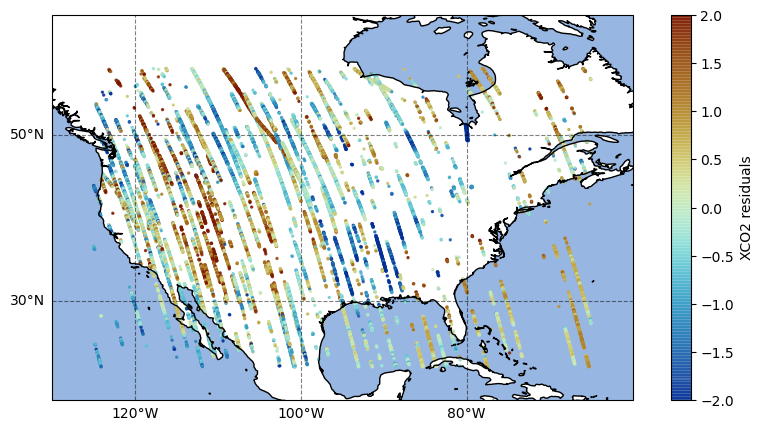

In [10]:
plot.plot_df(
    df_xco2, "xco2_residuals_std", vmin=-2, vmax=2, cmap=cm.roma_r, label="XCO2 residuals"
)


In [11]:
df_xco2.to_csv("gridded_xco2_residuals_north_america.csv", index=False)